# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from migrator import *
from plotter import *
from co2_migrator import *

In [2]:
!pip install tabulate
!pip install seaborn

# Data leverage and analysis

In [3]:
all_metamodels = [] # [0] gives country, [1] gives emissions
countries_metamodels = []
migration_metamodels = []

for file in os.listdir("metamodels"):
    country_code = file[:2]
    if country_code == "EU":
        country_code = file[:6]

    metamodel = MetaModel(
            country_code=country_code,
            co2_emissions=pd.read_parquet("metamodels/" + file)["carbon_emission"].values
        )
    # remove the . in the country codes
    if "." in country_code:
        country_code = country_code.replace(".", "")
    metamodel.total_emissions *= SCALE_TO_MARCONI
    all_metamodels.append((country_code,metamodel.total_emissions))

    if len(country_code) > 2: # if EU-...
        migration_metamodels.append((country_code, metamodel.total_emissions))
    else:
        countries_metamodels.append((country_code, metamodel.total_emissions))

In [13]:
# the average of all countries
average_emissions = sum([x[1] for x in countries_metamodels]) / len(countries_metamodels)
average_emissions

2923.1757655172414

In [4]:
print("Country \t Total kgCO2")
for metamodel in all_metamodels:
    print(f"{metamodel[0]:<15}{metamodel[1]:>0.2f}")

Country 	 Total kgCO2
DK             1647.46
HU             6600.16
SE             99.20
EU-8h          82.70
BA             7401.92
CH             81.31
EU-15m         72.76
IT             1529.37
RS             6176.32
RO             2195.55
EU-4h          75.15
GR             1979.85
FR             225.24
PT             827.01
LV             486.07
EU-1h          72.76
BG             2489.77
DE             13401.11
EE             3222.95
NL             4196.87
AT             654.65
HR             1561.77
SK             732.18
EU-24h         140.95
MK             8827.91
CZ             3526.51
PL             7370.91
FI             184.69
LU             780.89
NO             103.77
ES             3740.62
LT             1032.37
BE             723.83
SI             2971.86


# Violin plot - total emissions of 29 metamodels

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


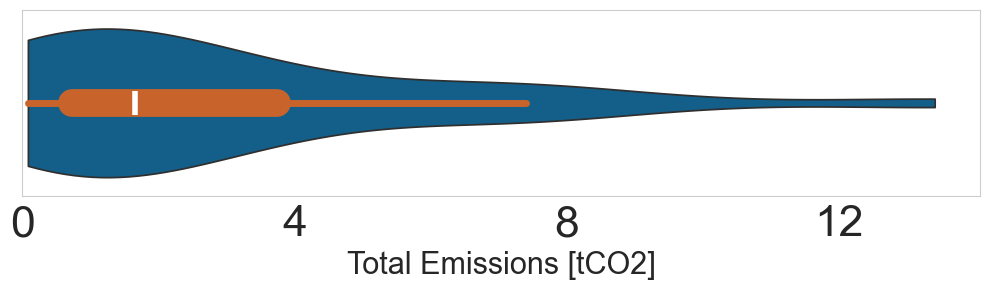

In [14]:
violin_data = pd.DataFrame({
    'Country': [x[0] for x in countries_metamodels],
    'Total CO2': [x[1] / 1e3 for x in countries_metamodels]
})

plt.figure(figsize=(10, 3))
sns.violinplot(
    data=violin_data,
    x=violin_data['Total CO2'],
    inner_kws=dict(box_width=20, whis_width=5, color='#C8642B'),
    color='#00649D',
    density_norm='width',
    cut=0
)
plt.grid(False)
plt.xlabel('Total Emissions [tCO2]', fontsize=22)
plt.xlim(0, None)

# tick lines size of 30
plt.xticks(fontsize=32, ticks=[0, 4, 8, 12])

plt.tight_layout()
plt.savefig('plots/exp3-violin-plot.pdf')

# 10 lowest CO2 emissions

In [6]:
all_metamodels.sort(key=lambda x: x[1])
all_metamodels

[('EU-15m', 72.7608),
 ('EU-1h', 72.7608),
 ('EU-4h', 75.14639999999999),
 ('CH', 81.30919999999999),
 ('EU-8h', 82.7008),
 ('SE', 99.2012),
 ('NO', 103.77359999999999),
 ('EU-24h', 140.9492),
 ('FI', 184.68519999999998),
 ('FR', 225.2404),
 ('LV', 486.066),
 ('AT', 654.6483999999999),
 ('BE', 723.8307999999998),
 ('SK', 732.1804),
 ('LU', 780.8864),
 ('PT', 827.008),
 ('LT', 1032.3683999999998),
 ('IT', 1529.3684),
 ('HR', 1561.7728),
 ('DK', 1647.4556),
 ('GR', 1979.8491999999999),
 ('RO', 2195.5472),
 ('BG', 2489.7711999999997),
 ('SI', 2971.8612),
 ('EE', 3222.9456),
 ('CZ', 3526.5131999999994),
 ('ES', 3740.6207999999997),
 ('NL', 4196.8668),
 ('RS', 6176.3184),
 ('HU', 6600.16),
 ('PL', 7370.9076),
 ('BA', 7401.920399999999),
 ('MK', 8827.9128),
 ('DE', 13401.108)]

In [7]:
all_metamodels.sort(key=lambda x: x[1])
lowest_10_models = all_metamodels[:10]
lowest_10_emissions = [x[1] for x in lowest_10_models]
lowest_10_countries = [x[0] for x in lowest_10_models]


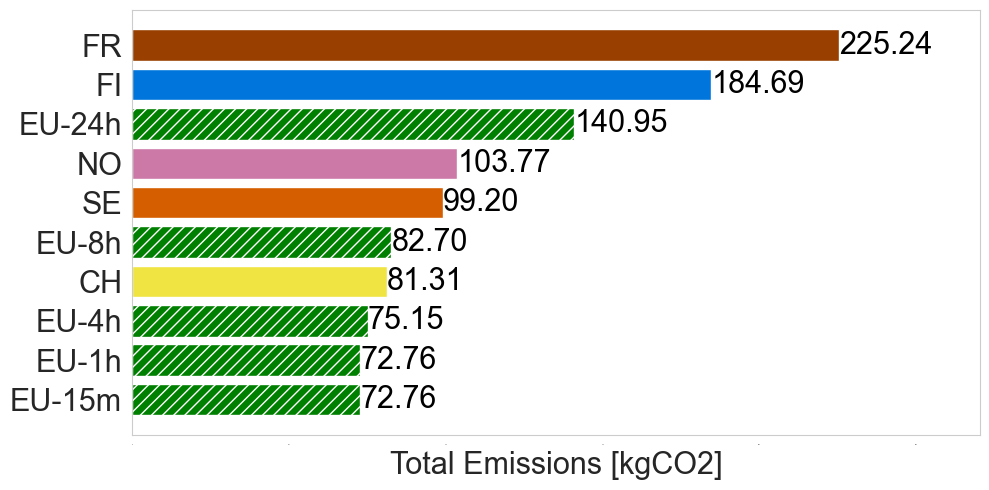

In [8]:
plt.figure(figsize=(10, 5))
bars = plt.barh(lowest_10_countries, lowest_10_emissions, color=['green' if emission in [x[1] for x in migration_metamodels] else colorblind_friendly_colors[i] for i, emission in enumerate(lowest_10_emissions)])
plt.xlabel('Total Emissions [kgCO2]', fontsize=22)
plt.xlim(0, max(lowest_10_emissions) * 1.2)
plt.yticks(fontsize=22)  # Adjusted for better visibility and fit
# plt.ylabel('Country Code', fontsize=22)
plt.xticks(fontsize=0)  # Adjusted for better visibility and fit

for bar, emission in zip(bars, lowest_10_emissions):
    # if it is an eu bar, then give is a special pattern
    if emission in [x[1] for x in migration_metamodels]:
        bar.set_hatch('///')

    # if the text contains a dot, remove the dot
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{emission:.2f}',
             va='center', ha='left', fontsize=22, color='black')

# grid off
plt.grid(False)
plt.tight_layout()
plt.savefig('plots/exp3-lowest-10-emissions.pdf')
# just vertical grid


# All CO2 emissions

In [9]:
# Prepare the data
all_emissions = [x[1] for x in all_metamodels]
all_countries = [x[0] for x in all_metamodels]

#### Linear scale

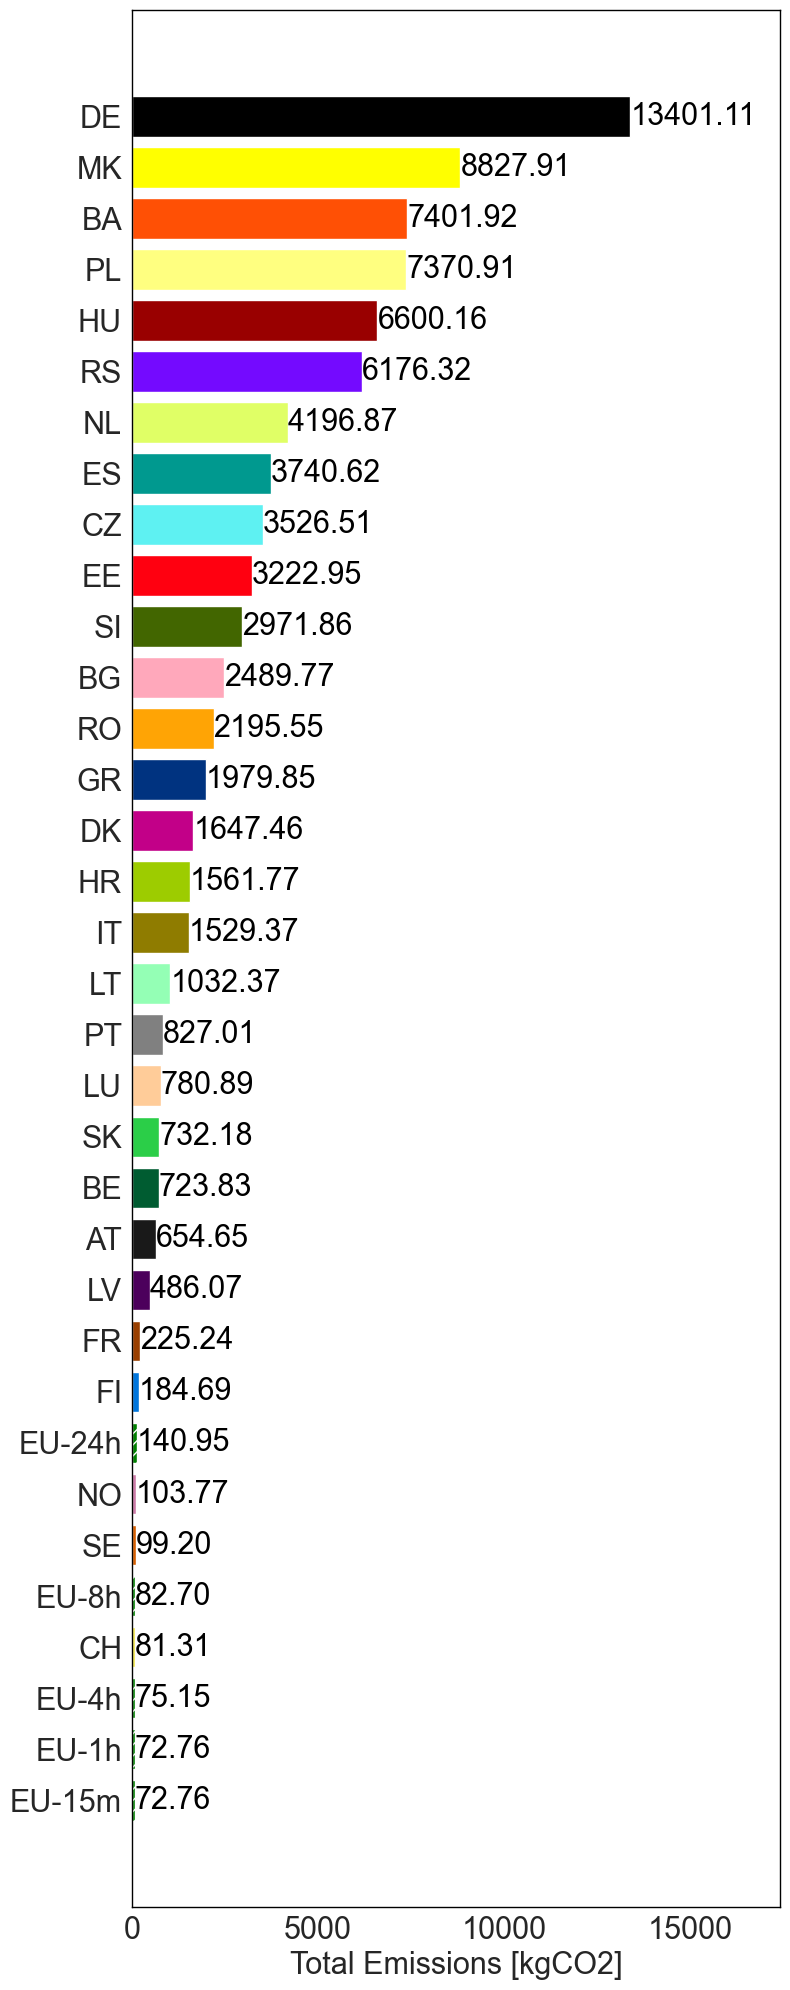

In [10]:
plt.figure(figsize=(8, 20))
bars = plt.barh(all_countries, all_emissions, color=['green' if emission in [x[1] for x in migration_metamodels] else colorblind_friendly_colors[i] for i, emission in enumerate(all_emissions)])
plt.xticks(fontsize=22, ticks=[0, 5000, 10000, 15000])  # Adjusted for better visibility and fit
plt.xlabel('Total Emissions [kgCO2]', fontsize=22)
plt.yticks(fontsize=22)  # Adjusted for better visibility and fit

plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(1)

# make it logarithmic sclae
plt.xlim(0, max(all_emissions) * 1.3)

for bar, emission in zip(bars, all_emissions):
    if emission in [x[1] for x in migration_metamodels]:
        bar.set_hatch('///')  # Setting pattern for specific bars
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{emission:.2f}',
             va='center', ha='left', fontsize=22, color='black')  # Text formatting

plt.grid(False)  # Ensure grid is off
plt.tight_layout()
plt.savefig('plots/exp3-all-emissions-linear-scale.pdf')

#### Logarithmic scale

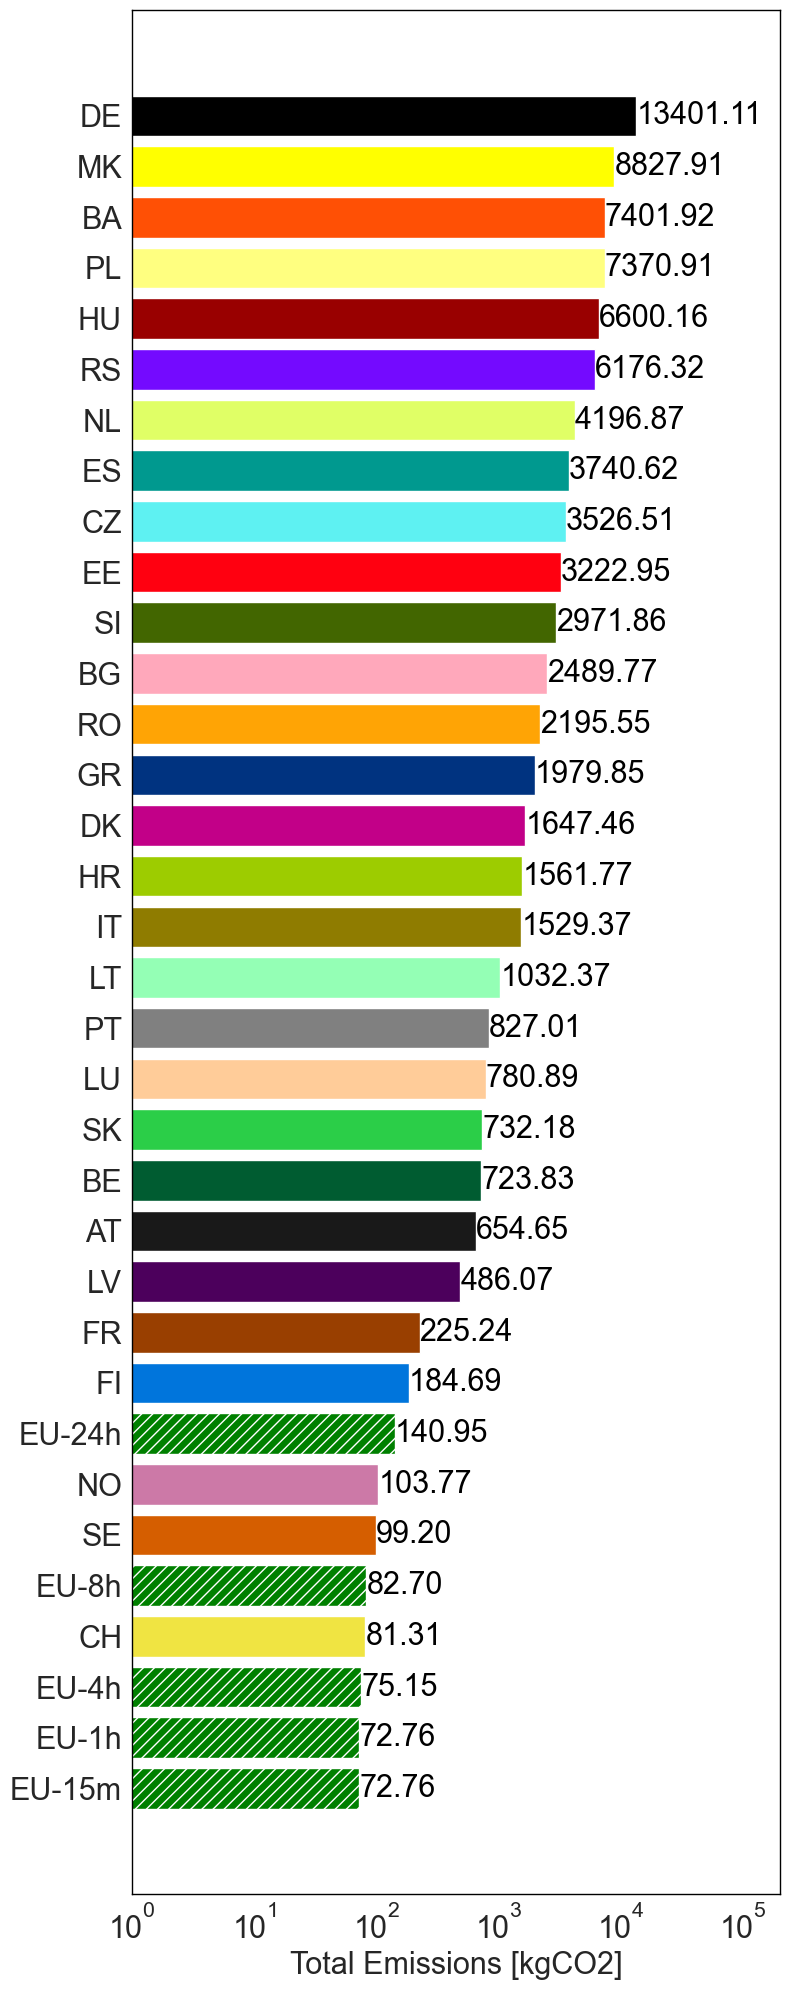

In [11]:
plt.figure(figsize=(8, 20))
bars = plt.barh(all_countries, all_emissions, color=['green' if emission in [x[1] for x in migration_metamodels] else colorblind_friendly_colors[i] for i, emission in enumerate(all_emissions)])
plt.xlabel('Total Emissions [kgCO2]', fontsize=22)

plt.yticks(fontsize=22)  # Adjusted for better visibility and fit
plt.xticks(fontsize=22, ticks=plt.xticks()[0], labels=[])  # Adjusted for better visibility and fit

plt.gca().spines['top'].set_color('black')
plt.gca().spines['top'].set_linewidth(1)
plt.gca().spines['right'].set_color('black')
plt.gca().spines['right'].set_linewidth(1)
plt.gca().spines['left'].set_color('black')
plt.gca().spines['left'].set_linewidth(1)
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['bottom'].set_linewidth(1)

# make it logarithmic sclae
plt.xscale('log')
plt.xlim(1, 200000)

for bar, emission in zip(bars, all_emissions):
    if emission in [x[1] for x in migration_metamodels]:
        bar.set_hatch('///')  # Setting pattern for specific bars
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{emission:.2f}',
             va='center', ha='left', fontsize=22, color='black')  # Text formatting

plt.grid(False)  # Ensure grid is off
plt.tight_layout()
plt.savefig('plots/exp3-all-emissions-log-scale.pdf')